In [1]:
#%reset -f
import pandas as pd
import numpy as np

import datetime as dt
import random
import time
import math
import itertools
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import scipy.integrate as integrate
import seaborn as sns
from scipy.stats import gaussian_kde
import scipy.signal as sig
from IPython.display import clear_output
from graphviz import Digraph
from threading import Thread
import threading
import queue

/home/rute/.conda/envs/pesquisa/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
almNum = 3
ocorr = 100
t_sample = 60
base_hour = dt.datetime(2018, 1,9,9,0,0)
occor_num = 0

#Settings alarms
a = np.zeros(1, dtype=int)
ocorr = 10
duration = 120 #120sec
hour_init = base_hour

b = np.zeros(1, dtype=int)
pAb =0.2
delay_b = 60 #seconds
duration_b = 120

c = np.zeros(1, dtype=int)
pAc = 0.6
delay_c = 15 #seconds
duration_c = 120

#Alarm Series Generation, A (cause), B(Effect). C(Effect)
while(occor_num < ocorr): 
    
    #A generation - begin
    srtd_hour = random.normalvariate(3, 1)
    srtd_hour_begin = hour_init + dt.timedelta(hours=srtd_hour)
    srtd_hour_end = srtd_hour_begin + dt.timedelta(seconds = duration)

    idx_init_a_occor = int(math.ceil((srtd_hour_begin - base_hour).total_seconds()/t_sample))
    idx_end_a_occor = int(math.ceil((srtd_hour_end - base_hour).total_seconds()/t_sample))
        
    if(idx_end_a_occor > a.size):
            a.resize(idx_end_a_occor)

    for i in np.arange(idx_init_a_occor, idx_end_a_occor + 1):
        a[i-1] = 1
    #A generation - end
         
    
    #B generation begin
    srtd_prob_b = random.uniform(0,1)  
    if srtd_prob_b <= pAb:
        srtd_hour_begin_b = srtd_hour_begin + dt.timedelta(hours = delay_b/3600)
        srtd_hour_end_b = srtd_hour_begin_b + dt.timedelta(seconds=duration_b)

        idx_init_b_occor = int(math.ceil((srtd_hour_begin_b - base_hour).total_seconds()/t_sample))
        idx_end_b_occor = int(math.ceil((srtd_hour_end_b - base_hour).total_seconds()/t_sample))

        if(idx_end_b_occor > b.size):
                b.resize(idx_end_b_occor)

        for j in np.arange(idx_init_b_occor, idx_end_b_occor +1):
            b[j-1] =  1  

    #B generation end

    #C generation begin
    srtd_prob_c = random.uniform(0,1)
    if srtd_prob_c <= pAc:
        srtd_hour_begin_c = srtd_hour_begin + dt.timedelta(hours = delay_b/3600)
        srtd_hour_end_c = srtd_hour_begin_c + dt.timedelta(seconds=duration_c)

        idx_init_c_occor = int(math.ceil((srtd_hour_begin_c - base_hour).total_seconds()/t_sample))
        idx_end_c_occor = int(math.ceil((srtd_hour_end_c - base_hour).total_seconds()/t_sample))
        
        if(idx_end_c_occor > c.size):
            c.resize(idx_end_c_occor)

        for j in np.arange(idx_init_c_occor, idx_end_c_occor +1):
            c[j-1] = 1    
    #C generation end
    
    hour_init = srtd_hour_begin
    occor_num = occor_num + 1

#Making series the same length
max_len = max(a, b, c, key=len).size
a = np.concatenate([a, np.zeros(max_len - a.size)])
b = np.concatenate([b, np.zeros(max_len - b.size)])
c = np.concatenate([c, np.zeros(max_len - c.size)])
sum(a)

In [2]:
#Visualization in a seaborn corr mamtrix 
def plot_mat_corrs(figsize, annot, matrix):
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
    sns.heatmap(matrix, cmap=cmap, center=0, annot=annot, vmin = 0, vmax=max(matrix.max()))
    plt.yticks(rotation=45)
    plt.xticks(rotation=45)
    plt.show()

In [33]:
#Visualization by graph
def graph(df, limite, eng = 'dot'):
    g = Digraph(engine=eng)
    for k, row in enumerate(df.index):
        if any(df.iloc[k]>=limite) or any(df[row] >= limite):
            g.node(str(k),row, shape='oval', fontsize='10', width='0') 

    for j, col in enumerate(df.columns):
        for i, row in enumerate(df[col]):
            if row  >=limite:
                g.edge(str(i), str(j), label=str(np.round(row,3)),\
                       color="#000000{:02x}".format(int(255)))
                
                       #* row//max(df.max()))
    return g    

In [22]:
def get_lim_index(cdf, lim):
    summation = 0
    index = 0
    for i in np.arange(0, cdf.size):
        if cdf[i] > lim:
            index = i
            break
    return index
    

In [7]:
def surrogate(a):
    a_diff = np.diff(a)
    begin = np.where(a_diff > 0)[0]
    end = np.where(a_diff < 0)[0]
    
    if begin.size > end.size:
        end = np.append(end, a.size)
    elif begin.size < end.size:
        begin = np.insert(begin, 0, 0) 
    elif begin.size == 0 and end.size == 0:
        return a.copy()
    elif np.all(begin > end):
        begin = np.insert(begin, 0, 0)
        end = np.append(end, a.size)
    
    n_seq = np.max([begin.size, end.size])
    a_surr = np.zeros(a.shape)
    p_seq = np.random.randint(0, a.size - max(end - begin), size=n_seq)
    for i in np.random.permutation(n_seq):
        len_seq = end[i] - begin[i]
        a_surr[p_seq[i]:p_seq[i] + len_seq] = a[begin[i]:end[i]]
    return a_surr

In [8]:
#Method using stats model kde to return transfer etnropy value limit. That is, the 'x' value corresponding to P95
def significance_test(k,l,h,sup_lim, n, a,b):
    '''
        significance_test(a,b,k,l,h,sup_lim, n)
    '''
    transferEntropies = []    
    
    np.random.seed(int(time.time()))
    for i in np.arange(0,n):
        surrogate_a = surrogate(a.copy())
        transferEntropies.append(te(k,l,h,surrogate_a[:],b, 'serie_a', 'serie_b'))
        
    kde = sm.nonparametric.KDEUnivariate(transferEntropies)
    kde.fit()
    
    
    lvl_sig = kde.icdf[get_lim_index(kde.cdf, sup_lim)]
    return lvl_sig

In [9]:
def joint_probability(k,l, h, a, b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        a, b array type'''

    #Alarm Series A (cause), B (effect), same len
    #tested
    sizeSeries = a.size
    transEntropy = 0
    numStates = 2**(k + l  + 1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    counting = np.zeros(numStates)
    prob_cnjt = np.zeros(numStates)
    a_prob_ind = []
    b_prob_ind = []
    #joitn probability p(i_sub_t+1), i_sub_t**k, j_sub_t**l)
    inicio = np.max([k,l]) - 1
    for i in np.arange(inicio, sizeSeries - h):
        for hk in np.arange(0,k):
                b_prob_ind.append(b[i - hk])
        for hl in np.arange(0,l):
                a_prob_ind.append(a[i - hl])

        ab = [b[i + h]] + b_prob_ind + a_prob_ind 
        index_comb = combinations.index(ab)
        counting[index_comb] = counting[index_comb] + 1

        a_prob_ind = []
        b_prob_ind = []

    total = sum(counting)
    for i, cnt in enumerate(counting):
        if total != 0:
            prob_cnjt[i] = cnt/total
     
    return prob_cnjt

In [10]:
##for paper test
def joint_probability_new(k,l,h, a, b, lbl_a, lbl_b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        a, b array type'''
    
    numStates=2**(k+l+1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    prob_cnjt = np.zeros(numStates)
    
    #Alarm Series A (cause), B (effect), same len
    #teste   

    matrix_nova = np.matrix([b[1:],b[:-1],a[:-1]]).T
    df = pd.DataFrame(matrix_nova, columns = ['b_ftr', lbl_b, lbl_a])
    gpd = df.groupby(['b_ftr', lbl_b, lbl_a], as_index=False).size().reset_index(name='Count')
    total = sum(gpd['Count'])
    
    for i in np.arange(0,gpd.shape[0]):
        comb = [e for e in gpd.iloc[i][0:3].values.tolist()]
        idx = combinations.index(comb)
        prob_cnjt[idx] = gpd.iloc[i]['Count']/total

    return prob_cnjt

In [11]:
#Joint probability evaluation p(i_t+h, i_t**k)
#tested
def joint_prob_ih_ik(k,l, joint_prob_ih_ik_jl):
    states_ith_ik = list(map(list, itertools.product([0, 1], repeat=k + 1)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1))) 
    p_jnt_ith_ik = np.zeros(2**(k+1))
    
    for i, state in enumerate(states_ith_ik):
        for j, comb in enumerate(combinations):
            if comb[0:k+1] == state:
                p_jnt_ith_ik[i] = p_jnt_ith_ik[i] + joint_prob_ih_ik_jl[j]
    return p_jnt_ith_ik

In [12]:
def conditional_prob(k,l,joint_prob):
    states = list(map(list, itertools.product([0, 1], repeat=k+l)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))

    size = int(joint_prob.size/2)
    conditional = np.zeros(2**(k+l+1))

    for i,state in enumerate(states):
        index_zero = combinations.index([0] + state)
        prob_zero = joint_prob[index_zero]

        index_one = combinations.index([1] + state)
        prob_one = joint_prob[index_one]

        if(prob_zero + prob_one != 0):
            conditional[i] = prob_zero/(prob_zero+ prob_one)
            conditional[i + 2**(k+l)] = prob_one/(prob_zero+ prob_one)
    return conditional

In [13]:
#Division of the conditionals in log2 
#tested
def conditional_div(k,l,conditional_num, conditional_den):
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    conditional_division = np.zeros(conditional_num.size)
    states_den = list(map(list, itertools.product([0, 1], repeat=1+k)))
    for j, comb in enumerate(combinations):
        if(conditional_den[states_den.index(comb[0:k+1])] != 0):
            conditional_division[j] = conditional_num[j]/conditional_den[states_den.index(comb[0:k+1])]            
    return conditional_division

In [14]:
#Transfer entropy final evaluation
def te(k,l,h,a,b, lbl_a, lbl_b):
    '''
        transentropy a->b
        te(k,l,h,a,b)
        k - dimension of b
        l - dimension of aDataFrame count duplicate rows and ...
        h -> instant in the future of a
    '''
    joint_p_ih_ik_jl = joint_probability_new(k,l,h,a,b, lbl_a, lbl_b)
    #joint_p_ih_ik_jl = joint_probability(k,l,h,a,b)
    
    joint_p_ih_ik = joint_prob_ih_ik(k,l, joint_p_ih_ik_jl)
    conditional_num = conditional_prob(k,l,joint_p_ih_ik_jl)
    conditional_den = conditional_prob(k,0, joint_p_ih_ik)    
    
    div = conditional_div(k,l,conditional_num, conditional_den)
    
    #log2 from the division of the conditionals -> #p(i_sub_t+h|i_sub_t**k, j_sub_t**l) /p(i_sub_t+h|i_t**k)
    
    log2_div_cond = np.log2(div[div!=0])
    te = np.sum(joint_p_ih_ik_jl[div!=0]*log2_div_cond)
    return te

In [45]:
def transferEnteropy_case(dist_df, pcnt_sig):
    start = time.clock()
    transEntropy = np.zeros([dist_df.columns.size,dist_df.columns.size])
    sigValues =  np.zeros([dist_df.columns.size,dist_df.columns.size])
    for i in np.arange(0, dist_df.columns.size):
        for j in np.arange(0, dist_df.columns.size):
            print('trans ', dist_df.columns[i], dist_df.columns[j])
            if(j != i + dist_df.columns.size/2 and j!=i and j != i - dist_df.columns.size/2):
                transEntropy[i][j] = te(1,1,1,dist_df[dist_df.columns[i]],
                                         dist_df[dist_df.columns[j]],'serie_a', 'serie_b')

#                 sigValues[i][j] = significance_test(1,1,1,pcnt_sig,100,dist_df[dist_df.columns[i]],
#                                                      dist_df[dist_df.columns[j]])
            clear_output()
            
            
#     for i, j in zip(np.arange(0, transEntropy.shape[0]), np.arange(0, sigValues.shape[0])):
#         for k, l in zip(np.arange(0, transEntropy.shape[1]), np.arange(0, sigValues.shape[1])):
#             if transEntropy[i][k] != 0 and transEntropy[i][k]<= sigValues[j][l]:
#                 transEntropy[i][k] = 0
    end = time.clock()   
    
    print(end - start)
    return transEntropy  

In [61]:
#Leitura dos dados
#Variavéis analizadas 1,2,3,7,8,9,21

dist6 = pd.read_csv('dist6.csv', names=['xmeas%02d_low' % x for x in range(1, 74)] + ['xmeas%02d_high' % x for x in range(1, 74)])
dist6_sel_vars = dist6[['xmeas01_low', 'xmeas02_low', 'xmeas03_low', 
        'xmeas08_low', 'xmeas09_low', 'xmeas21_low',
        'xmeas01_high', 'xmeas02_high', 'xmeas03_high',
        'xmeas08_high', 'xmeas09_high', 'xmeas21_high']].copy()



In [ ]:
#Data post processing

In [ ]:
dist6_resamp#Moving mean application

window = 1 #window of moving mean
dist_roll  = dist6_sel_vars.rolling(window).mean() 
dist_roll.dropna(inplace=True)
dist_roll = dist_roll.round(decimals=0,).copy()
dist_roll.reset_index(drop=True, inplace=True)

In [ ]:
#Resampling application - Method 1

df = dist_roll  #df which will be resampled
num_samp =  10 #number of samples that will be grouped
rate_samp = (num_samp*36)/3600 #rate in hours
total_samp = df.shape[0]*0.01/rate_samp

dist6_resamp = pd.DataFrame([], columns= df.columns)
for col in df.columns:
    dist6_resamp[col] = np.abs(np.round(sig.resample(df[col],int(np.round(total_samp)))))

In [ ]:
#Resampling application - Method 2 

df = dist_roll #df which will be resampled

num_gpd_samples = 10 #num of samples to be grouped 

dist6_resamp = df.groupby(lambda i: i // num_gpd_samples).agg(lambda g: 0 if np.sum(g) < num_gpd_samples/2 else 1)

In [ ]:
#Cenario 1 - 

#Moving mean application

window = 5 #window of moving mean
dist_roll  = dist6_sel_vars.rolling(window).mean() 
dist_roll.dropna(inplace=True)
dist_roll = dist_roll.round(decimals=0,).copy()
dist_roll.reset_index(drop=True, inplace=True)

te_matrix = transferEnteropy_case(dist_roll, 0.99) 



In [ ]:
df_te =  pd.DataFrame(te_matrix, columns = dist6_sel_vars.columns, index= dist6_sel_vars.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
graph(df_te, 'dot')

In [ ]:
#Cenario 2 


df_2 = dist6_sel_vars #df which will be resampled

num_gpd_samples = 10 #num of samples to be grouped 

dist6_c2_resamp = df_2.groupby(lambda i: i // num_gpd_samples).agg(lambda g: 0 if np.sum(g) < num_gpd_samples/2 else 1)

te_matrix = transferEnteropy_case(dist6_c2_resamp, 0.99) 

df_te =  pd.DataFrame(te_matrix, columns = dist6_c2_resamp.columns, index= dist6_c2_resamp.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
graph(df_te, 'dot')

1.2831370000000106


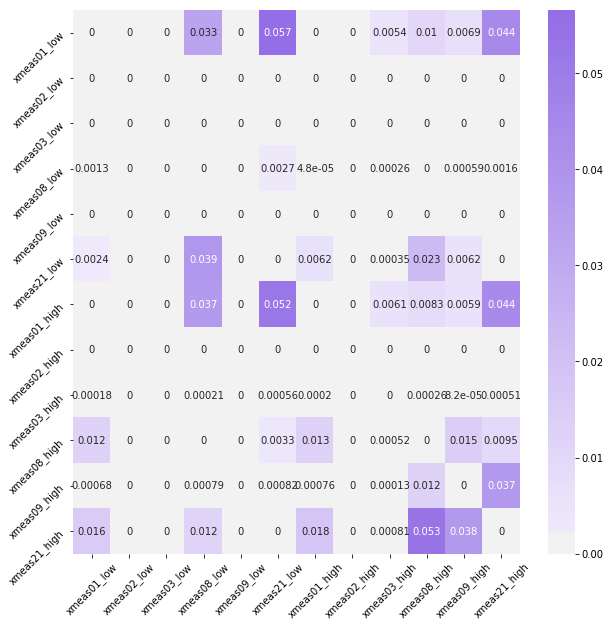

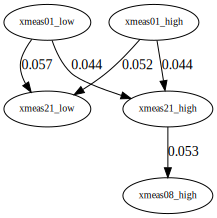

In [62]:
#Cenario 3 

window = 5 #window of moving mean
dist_roll_3  = dist6_sel_vars.rolling(window).mean() 
dist_roll_3.dropna(inplace=True)
dist_roll_3 = dist_roll_3.round(decimals=0,).copy()
dist_roll_3.reset_index(drop=True, inplace=True)

df = dist_roll_3 #df which will be resampled

num_gpd_samples = 10 #num of samples to be grouped 

dist6_resamp_c3 = df.groupby(lambda i: i // num_gpd_samples).agg(lambda g: 0 if np.sum(g) < num_gpd_samples/2 else 1)

te_matrix = transferEnteropy_case(dist6_resamp_c3, 0.99) 

df_te =  pd.DataFrame(te_matrix, columns = dist6_resamp_c3.columns, index= dist6_resamp_c3.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
t = np.mean(te_matrix) + 3*np.std(te_matrix)
graph(df_te,t, 'dot')

In [ ]:
#Cenario 4 
dist6_c4 = dist6[['xmeas%02d_low' % x for x in [1,8,21]] + ['xmeas%02d_high' % x for x in [1,8,21]]]
te_matrix = transferEnteropy_case(dist6_c4, 0.99) 
df_te =  pd.DataFrame(te_matrix, columns = dist6_c4.columns, index= dist6_c4.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
graph(df_te, 'dot')

27.769757999999996


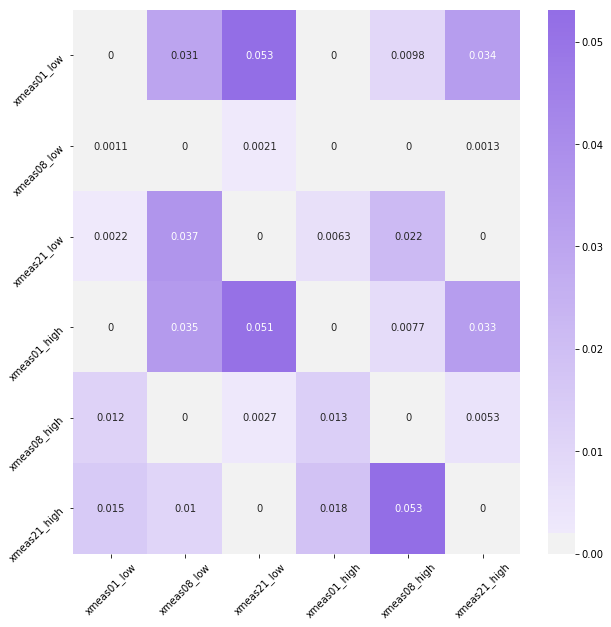

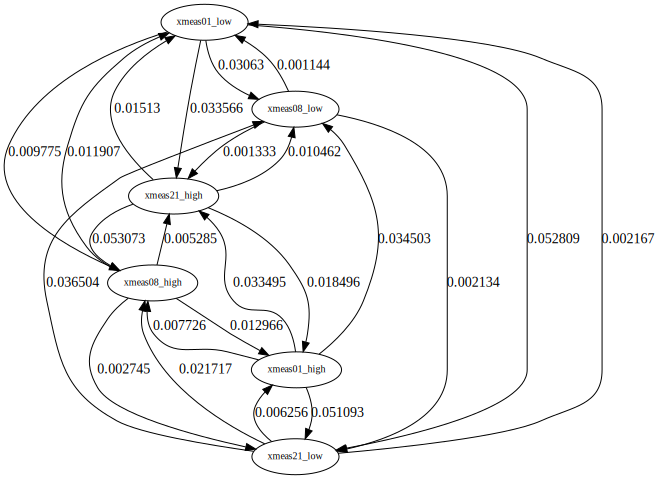

In [23]:
#Variaveis Selcionandas, media movel e resample ( conf - 5)

dist6_c5 = dist6[['xmeas%02d_low' % x for x in [1,8,21]] + ['xmeas%02d_high' % x for x in [1,8,21]]]


window = 5 #window of moving mean
dist_roll_5  = dist6_c5.rolling(window).mean() 
dist_roll_5.dropna(inplace=True)
dist_roll_5 = dist_roll_5.round(decimals=0,).copy()
dist_roll_5.reset_index(drop=True, inplace=True)

df = dist_roll_5.copy()  #df which will be resampled
num_samp =  10 #number of samples that will be grouped
rate_samp = (num_samp*36)/3600 #rate in hours
total_samp = df.shape[0]*0.01/rate_samp

dist6_c5_resamp = pd.DataFrame([], columns= df.columns)
for col in df.columns:
    dist6_c5_resamp[col] = np.abs(np.round(sig.resample(df[col],int(np.round(total_samp)))))

dist6_c5_resamp.head()    
te_matrix = transferEnteropy_case(dist6_c5_resamp, 0.999) 

df_te =  pd.DataFrame(te_matrix, columns = dist6_c5_resamp.columns, index= dist6_c5_resamp.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
graph(df_te, 'dot')

In [20]:
dist6_c5_resamp.shape

(5120, 6)

In [ ]:
#Cenário 6 - 

dist6_c6 = dist6[['xmeas%02d_low' % x for x in [1,8,21]] + ['xmeas%02d_high' % x for x in [1,8,21]]]


window = 5 #window of moving mean
dist_roll_6  = dist6_c6.rolling(window).mean() 
dist_roll_6.dropna(inplace=True)
dist_roll_6 = dist_roll_6.round(decimals=0,).copy()
dist_roll_6.reset_index(drop=True, inplace=True)

te_matrix = transferEnteropy_case(dist_roll_6, 0.99) 

df_te =  pd.DataFrame(te_matrix, columns = dist_roll_6.columns, index= dist_roll_6.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
graph(df_te, 'dot')

In [17]:

#Configuracao 8 - somente periodos de disturbio (Media movel e resample)

def select_dist_period(df, normal_w, abnormal_w):
    df_disturb =  pd.DataFrame([], columns = df.columns)
    series_dist = pd.Series([])
    n = 0
    for col in df.columns:
        while n < df.shape[0]:
            series_dist = series_dist.append(pd.Series(df[col][n:n+abnormal_w]))
            n= n + normal_w + abnormal_w
        df_disturb[col] = series_dist
    return df_disturb
dist6_c8 = select_dist_period(dist6_sel_vars, 800,200)


87.64280000000001


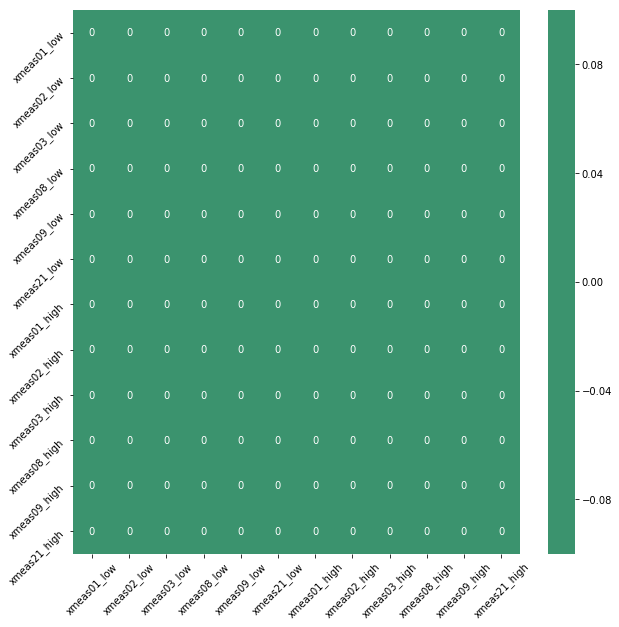

In [18]:

window = 1 #window of moving mean
dist_roll_8  = dist6_c8.rolling(window).mean() 
dist_roll_8.dropna(inplace=True)
dist_roll_8 = dist_roll_8.round(decimals=0,).copy()
dist_roll_8.reset_index(drop=True, inplace=True)

df = dist_roll_8  #df which will be resampled
num_samp =  10 #number of samples that will be grouped
rate_samp = (num_samp*36)/3600 #rate in hours
total_samp = df.shape[0]*0.01/rate_samp

# dist6_c8_resamp = pd.DataFrame([], columns= dist6_c8.columns)
# for col in df.columns:
#     dist6_c8_resamp[col] = np.abs(np.round(sig.resample(df[col],int(np.round(total_samp)))))

te_matrix = transferEnteropy_case(dist_roll_8, 0.5) 

df_te =  pd.DataFrame(te_matrix, columns = dist_roll_8.columns, index= dist_roll_8.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)
graph(df_te, 'dot')

1.2656299999999874


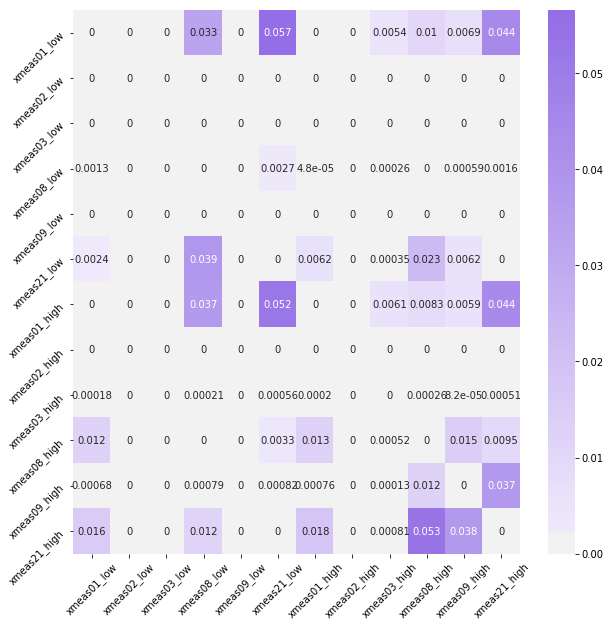

In [46]:
window =5 #window of moving mean

dist6_novo = pd.read_csv("dist6_3horas_sig/alm_seq.csv")
dist6_novo.drop('tout', axis=1, inplace=True)

dist = dist6_novo[['xmeas%02d_low' % x for x in [1,2,3,8,9,21]] + ['xmeas%02d_high' % x for x in [1,2,3,8,9,21]]]
roll  = dist6_sel_vars.rolling(window).mean() 
roll.dropna(inplace=True)
roll = roll.round(decimals=0,).copy()
roll.reset_index(drop=True, inplace=True)

# df = dist_roll_3 #df which will be resampled

df = roll
num_gpd_samples = 10 #num of samples to be grouped 

dist_resamp= df.groupby(lambda i: i // num_gpd_samples).agg(lambda g: 0 if np.sum(g) < num_gpd_samples/2 else 1)

te_matrix = transferEnteropy_case(dist_resamp, 0.99 )

df_te =  pd.DataFrame(te_matrix, columns = dist_resamp.columns, index= dist_resamp.columns)
plot_mat_corrs(figsize=(10,10), annot=True, matrix = df_te)


In [55]:
t = np.mean(te_matrix) + 3*np.std(te_matrix)
t

0.038891257032917875

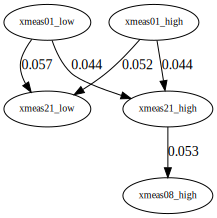

In [59]:

graph(df_te, t,'dot')

In [ ]:
#joint probablity for functions test
#joint_p_ih_ik_jl = np.array([0.97322404,0.00546448,0.00491803,0,0,0.00546448, 0.00546448, 0.00546448])

#aproximate results for this test

#p(ith, ik)
#jnt_p_ih_ik = [0.97868852,0.00491803,0.00546448,0.0109286] 

#p(i_t+h|i**k, j**l)
#cond_p_ih_ik_jl =  [1,0.5,0.4736841094123,0,0,0.5, 0.52631589085076,1]

#p(i_th|i_k)
#cond_p_ih_ik = [0.994711793480152,0.31035179088550,0.0552469991962,0.68964820911449]

In [ ]:
#np.savetxt("te_matrix_samp.csv", te_matrix, delimiter=",")